## [Test Set Mappings](#test_set_mappings)
## [Feature Extraction](#feature_extraction)
## [DNN Keras Model](#dnn_keras_model)
## [Classification Report](#classification_report)
## [Predictions Probability Distribution](#prob_distrib)
## [Test Images and Scoring](#test_images)
## [False Positives](#false_positives)
## [False Negatives](#false_negatives)

In [5]:
from keras.applications.vgg19 import VGG19
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input
from keras.models import Model
from IPython.display import SVG

from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.callbacks import ModelCheckpoint
from keras.utils import plot_model
from keras.utils.io_utils import HDF5Matrix

import numpy as np
import pandas as pd
import pydot
import graphviz
import h5py

from utils import *

import time
import random
from random import shuffle
from sklearn import cross_validation
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss, f1_score, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import matplotlib
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Create test set mappings <a id='test_set_mappings'></a>

**Indicate the path for each class folder**

In [6]:
class1_path = './data/test/renault/*.jpg' # address where to save the hdf5 file
class2_path = './data/test/other/*.jpg' # address where to save the hdf5 file

**List all images for each class**

In [7]:
import glob
class1_list = glob.glob(class1_path)
class2_list = glob.glob(class2_path)

class1_list = list(map(lambda path : path.replace('\\','/'), class1_list))
class2_list = list(map(lambda path : path.replace('\\','/'), class2_list))

print('Found', len(class1_list), 'class1 images.')
print('Found', len(class2_list), 'class2 images.')

Found 32 class1 images.
Found 28 class2 images.


**List all test images and their labels**

In [8]:
test_addrs = class1_list + class2_list
test_labels = [1 for number in range(len(class1_list))] + [0 for number in range(len(class2_list))]

# shuffle test data
c = list(zip(test_addrs, test_labels))
shuffle(c)
test_addrs, test_labels = zip(*c)

print('test_addrs:', len(test_addrs))
print('test_labels:', len(test_labels))

test_addrs: 60
test_labels: 60


**Save the test set mappings into a pandas dataframe**

In [9]:
test = pd.DataFrame({'image':test_addrs, 'label':test_labels})
test.to_csv('./munge/test.csv', sep=';', index=False)
test.head()

image  label
0              ./data/test/other/citroen_c3_7.jpg      0
1                 ./data/test/other/vw_polo_2.jpg      0
2               ./data/test/other/fiat_500_20.jpg      0
3  ./data/test/renault/renault_megane_jaune_1.jpg      1
4           ./data/test/other/toyota_yaris_11.jpg      0

# Extract features from a fully connected layer with VGG-19 model <a id='feature_extraction'></a>

**In this section, we will apply the same preprocessing pipeline as for modeling to extract feature values from test images.**

In [10]:
# Load the DNN model
base_model = VGG19(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc1').output)

In [11]:
# First helper function
def feature_extractor(img_path):
    """
    Args:
        img_path -- location of the image file on disk
    Returns:
        flatten_features -- a numpy ndarray containing all the values on the flatten layers of the network
    """
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    flatten_features = model.predict(x)
    return flatten_features

In [12]:
# Second helper function
def featurize_dataset(dataset, name):
    """
    This function take a dataframe contraining image addresses
    and their labels and create the corresponding HDF5 file
    
    Args:
        dataset -- pandas DataFrame containing two columns 'image' and 'label'
        name -- string indicating wether it is a 'train', 'cval', 'test' set    
    """
    
    # get the number of observations
    nobs = len(dataset)
    
    # choose proper data shape to save image features
    shape = (nobs, 4096)
    
    # specify location of output HDF5 file
    hdf5_path = './munge/'+name+'_vgg19_fc1.hdf5'
    
    # open a new hdf5 file and create arrays
    hdf5_file = h5py.File(hdf5_path, mode='w')
    hdf5_file.create_dataset('features', shape, np.int8)
    hdf5_file.create_dataset('labels', (nobs,), np.int8)
    hdf5_file['labels'][...] = dataset['label']
    
    # loop over image addresses
    for i in range(len(dataset)):
        
        # print how many observations are saved every 10%
        frac10 = nobs // 10
        if i % frac10 == 0:
            print('Featurizing '+name+' data set: {}/{}'.format(i, nobs))

        # extract the features for the image using VGG19 with predictions from the "fc1" layer
        features = feature_extractor(dataset['image'][i])

        # save the image features
        hdf5_file['features'][i, ...] = features
    
    # close hdf5 file
    hdf5_file.close()
    print('Done!')

**Apply the previous function to featurize the test dataset**

In [26]:
featurize_dataset(test, 'test')

Featurizing test data set: 0/60
Featurizing test data set: 6/60
Featurizing test data set: 12/60
Featurizing test data set: 18/60
Featurizing test data set: 24/60
Featurizing test data set: 30/60
Featurizing test data set: 36/60
Featurizing test data set: 42/60
Featurizing test data set: 48/60
Featurizing test data set: 54/60
Done!


# DNN Keras Model <a id='dnn_keras_model'></a>

**Now, we will load the previously trained Deep Neural Network and produce inference on the top of the VGG-19 fc1 layer.**

In [13]:
# Get test data (features and labels)
X_test = HDF5Matrix('./munge/test_vgg19_fc1.hdf5', 'features', start=0, end=None)
y_test = HDF5Matrix('./munge/test_vgg19_fc1.hdf5', 'labels', start=0, end=None)

In [14]:
# Verify all shapes
print('Shape of X_test:', X_test.shape)
print('Shape of Y_test', y_test.shape)

Shape of X_test: (60, 4096)
Shape of Y_test (60,)


In [15]:
# Create the model graph in Keras
model = Sequential()
model.add(Dense(1024, input_dim=X_test.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, input_dim=1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, input_dim=512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

In [16]:
# Load the DNN model
model.load_weights('./model/best_vgg19_dnn.hdf5')

# Evaluation

In [20]:
# Predict on test set
y_test_hat = model.predict(X_test, verbose=1).reshape(len(y_test))

60/60 [==============================] - 0s 100us/step


In [21]:
# get target values from test set
target = np.array(y_test)

In [22]:
# Get the best threshold
best_thresh = 0.6 # selection was made during in the modeling notebook

In [23]:
# Best performance
accuracy = accuracy_score(target, y_test_hat > best_thresh)
f1score = f1_score(target, y_test_hat > best_thresh, pos_label=1, average='binary')
auc = roc_auc_score(target, y_test_hat)

print('Accuracy = %.3f' % accuracy)
print('F1-score = %.3f' % f1score)
print('AUC = %.3f' % auc)

Accuracy = 0.917
F1-score = 0.915
AUC = 0.938


## Classification Report <a id='classification_report'></a>

In [24]:
print(classification_report(target, y_test_hat > best_thresh))

             precision    recall  f1-score   support

          0       0.85      1.00      0.92        28
          1       1.00      0.84      0.92        32

avg / total       0.93      0.92      0.92        60



Confusion matrix, without normalization
[[28  0]
 [ 5 27]]
Normalized confusion matrix
[[1.   0.  ]
 [0.16 0.84]]


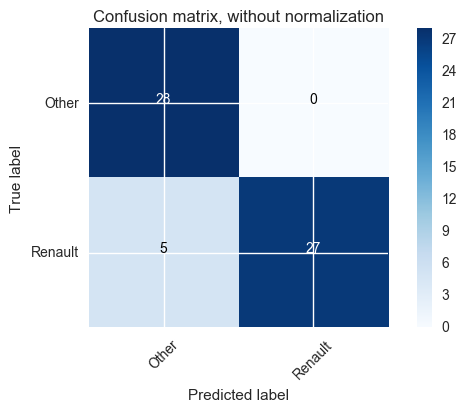

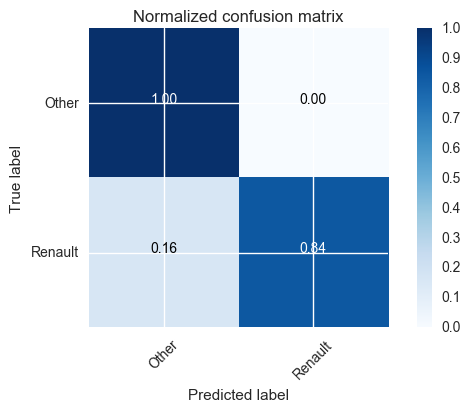

In [25]:
class_names = ['Other', 'Renault']

# Compute confusion matrix
cnf_matrix = confusion_matrix(target, y_test_hat > best_thresh)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

## Predictions Probability Distribution <a id='prob_distrib'></a>

(-0.01, 1.01)

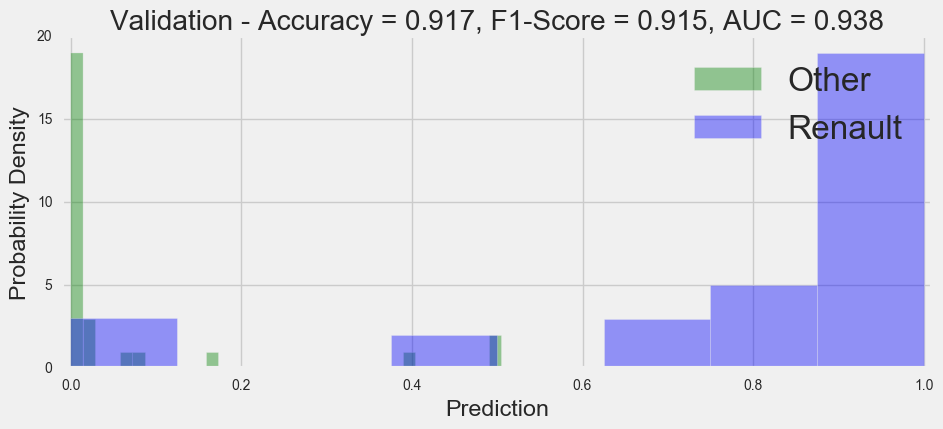

In [26]:
# Show prediction probability distribution
matplotlib.style.use('fivethirtyeight')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10,4)

plt.figure(); 
sns.distplot(y_test_hat[target==0], kde=False, color="g")
sns.distplot(y_test_hat[target==1], kde=False, color="b")

plt.legend(['Other','Renault'],fontsize=24)
plt.title('Validation - Accuracy = %.3f, F1-Score = %.3f, AUC = %.3f' %(accuracy, f1score, auc))
plt.xlabel('Prediction'); plt.ylabel('Probability Density'); plt.xlim(-0.01,1.01)

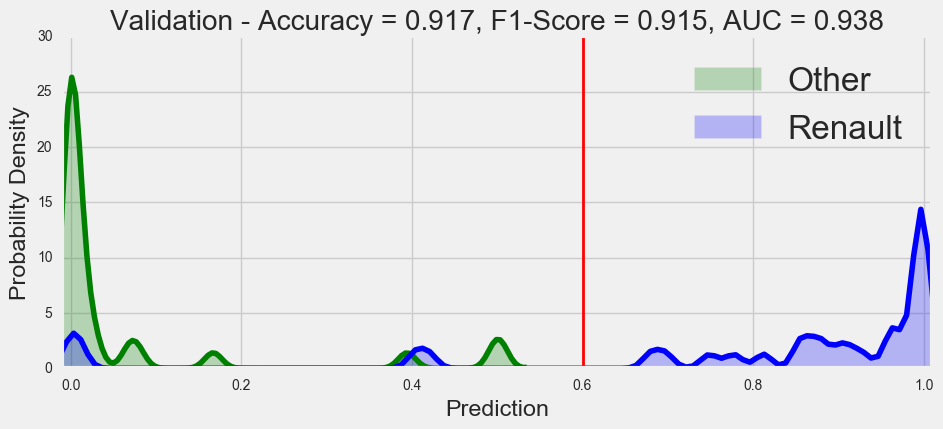

In [27]:
# show prediction density plot
matplotlib.style.use('fivethirtyeight')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10,4)

plt.figure();
sns.kdeplot(y_test_hat[target==0], shade=True, color="g", bw=0.01)
sns.kdeplot(y_test_hat[target==1], shade=True, color="b", bw=0.01)
plt.legend(['Other','Renault'],fontsize=24)
plt.title('Validation - Accuracy = %.3f, F1-Score = %.3f, AUC = %.3f' %(accuracy, f1score, auc))
plt.xlabel('Prediction'); plt.ylabel('Probability Density'); plt.xlim(-0.01,1.01)
plt.axvline(x=best_thresh, linewidth=2, color='red')

# Test Images and Scoring <a id='test_images'></a>

In [28]:
# Create a dataframe with image addresses and their predictions
predictions = test.copy()
predictions['pred'] = y_test_hat
print('Evaluated %d images' %len(predictions))
predictions.head()

Evaluated 60 images


image  label      pred
0              ./data/test/other/citroen_c3_7.jpg      0  0.748772
1                 ./data/test/other/vw_polo_2.jpg      0  0.497282
2               ./data/test/other/fiat_500_20.jpg      0  0.989723
3  ./data/test/renault/renault_megane_jaune_1.jpg      1  0.967861
4           ./data/test/other/toyota_yaris_11.jpg      0  0.001702

In [29]:
# set the number of class 1 images to observe into a 50-50 balanced dataset
# let's suppose class 1 as "Renault" and class 2 refering to "Other"
nclass2 = 5
random.seed(101)

class1_pred_img = list(predictions[predictions['label']==0]['image'])
class2_pred_img = list(predictions[predictions['label']==1]['image'])

class1_pred_img = [class1_pred_img[i] for i in random.sample(range(len(class1_pred_img)), nclass2)]
class2_pred_img = [class2_pred_img[i] for i in random.sample(range(len(class2_pred_img)), nclass2)]
pred_sample = predictions[predictions['image'].isin(class1_pred_img+class2_pred_img)]
pred_smaple = pred_sample.reset_index().drop(['index'], axis=1)
print('Observing', len(pred_sample), 'cross-validation examples')

Observing 10 cross-validation examples


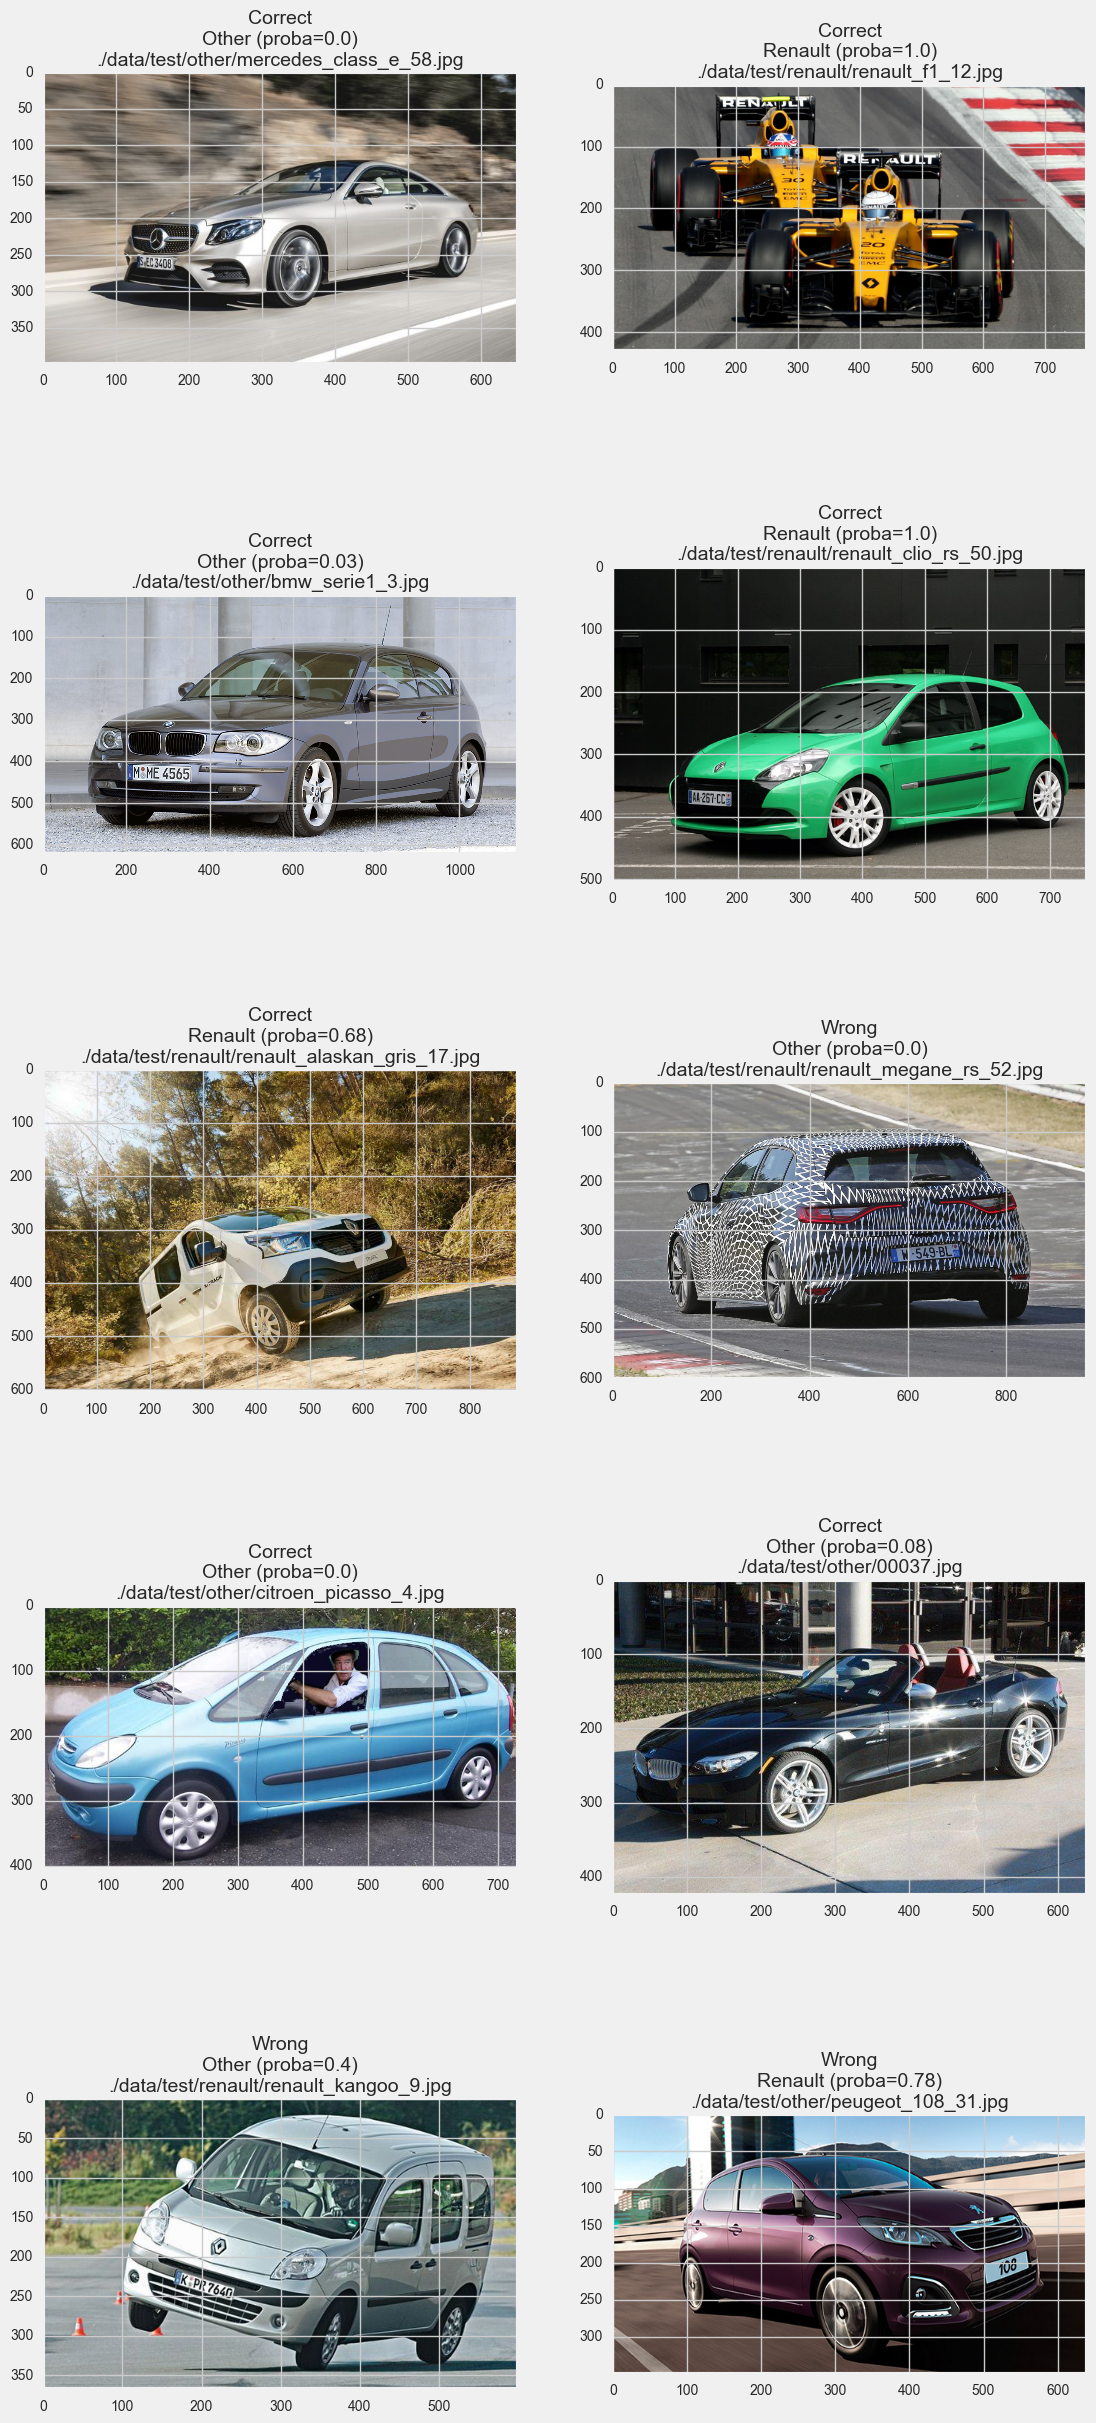

In [30]:
plot_img_score(pred_sample, best_thresh, labels=['Other', 'Renault'])

# False Positive Examples <a id='false_positives'></a>

Found 14 false positive exmaples.
Showing 2 observation(s):


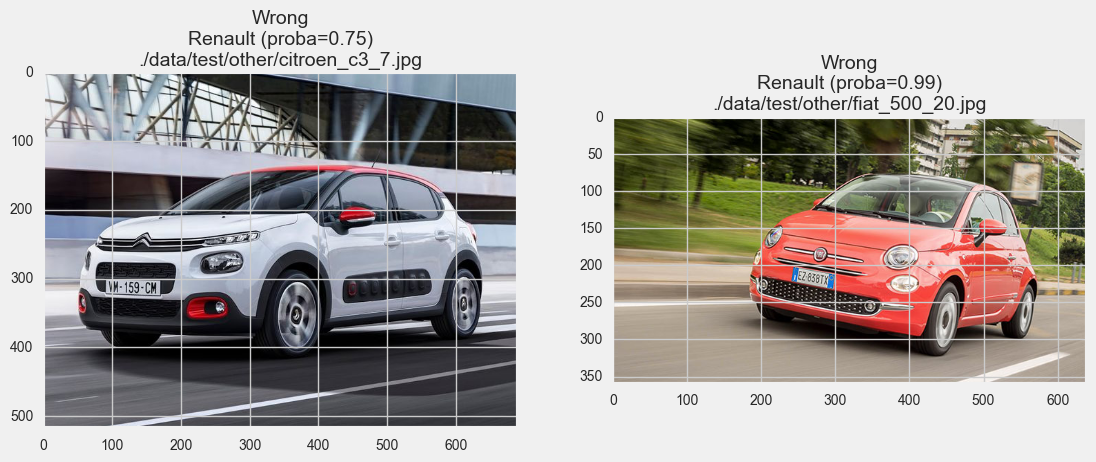

In [31]:
fp1 = predictions[(predictions['label'] == 0) & (predictions['pred'] > best_thresh)]
print('Found %.f false positive exmaples.' %len(fp1))
n_show = 2 if len(fp1)>2 else len(fp1)
print('Showing '+str(n_show)+' observation(s):')
plot_img_score(fp1.head(n_show), best_thresh, labels=['Other', 'Renault'])

In [32]:
pd.set_option('display.max_colwidth', -1)
fp1.head()

image  label      pred
0   ./data/test/other/citroen_c3_7.jpg               0      0.748772
2   ./data/test/other/fiat_500_20.jpg                0      0.989723
15  ./data/test/other/mercredes_formula1_car_21.jpg  0      0.880668
23  ./data/test/other/peugeot_5008_45.jpg            0      0.998395
26  ./data/test/other/00082.jpg                      0      0.873896

# False Negative Examples <a id='false_negatives'></a>

Found 19 false negative exmaples.
Showing 2 observations:


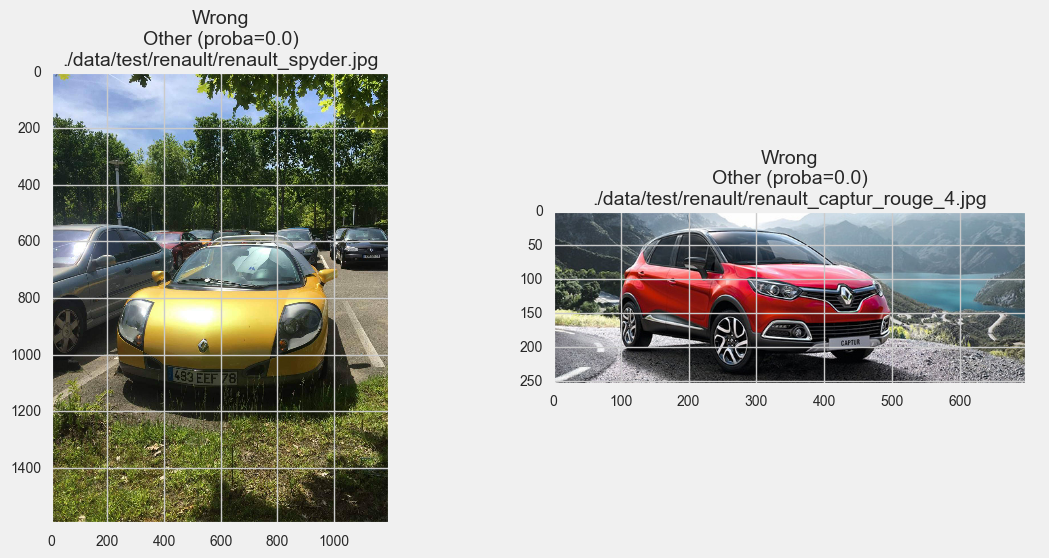

In [33]:
fn1 = predictions[(predictions['label'] == 1) & (predictions['pred'] < best_thresh)]
print('Found %.f false negative exmaples.' %len(fn1))
n_show = 2 if len(fn1)>2 else len(fn1)
print('Showing '+str(n_show)+' observations:')
plot_img_score(fn1.head(n_show), best_thresh, labels=['Other', 'Renault'])

In [34]:
fn1.head()

image  label          pred
6   ./data/test/renault/renault_spyder.jpg          1      7.054397e-08
7   ./data/test/renault/renault_captur_rouge_4.jpg  1      7.196165e-09
11  ./data/test/renault/renault_talisman_7.jpg      1      1.191980e-06
14  ./data/test/renault/renault_clio_rouge_56.jpg   1      5.045506e-01
16  ./data/test/renault/renault_talisman_58.jpg     1      4.496552e-12